In [38]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

(train_input, train_target), (test_input, test_target) =\
keras.datasets.fashion_mnist.load_data()
train_scaled = train_input / 255.0
train_scaled, val_scaled, train_target, val_target = train_test_split(train_scaled, train_target, test_size=0.2, random_state=42)

In [39]:
#모델을 만드는 함수 정의

def model_fn(a_layer=None):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(28, 28)))
    model.add(keras.layers.Dense(100, activation='relu'))
    
    if a_layer:
        model.add(a_layer)
    
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model

In [40]:
model = model_fn()
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_12 (Flatten)        (None, 784)               0         
                                                                 
 dense_24 (Dense)            (None, 100)               78500     
                                                                 
 dense_25 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=5, verbose=0)

In [42]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


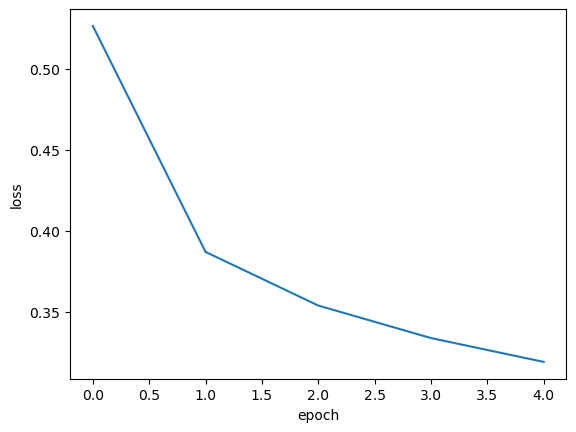

In [43]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

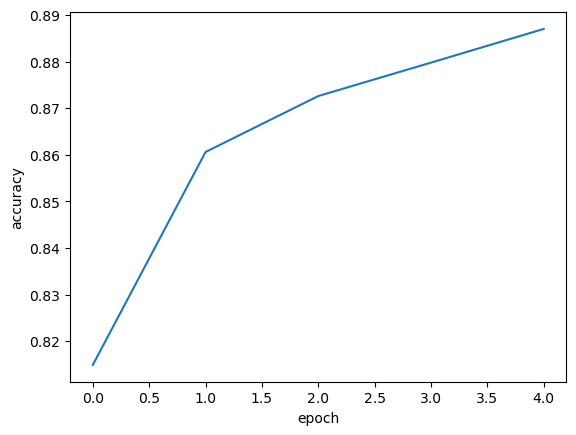

In [44]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')

plt.show()

epoch가 증가할 수록 손실은 줄어들고 정확도는 높아진다. 그러면 epoch를 계속해서 증가하면 성능이 완전히 올라가지 않을까?

다음은 epoch를 20까지 늘려서 모델을 학습시킨 코드.

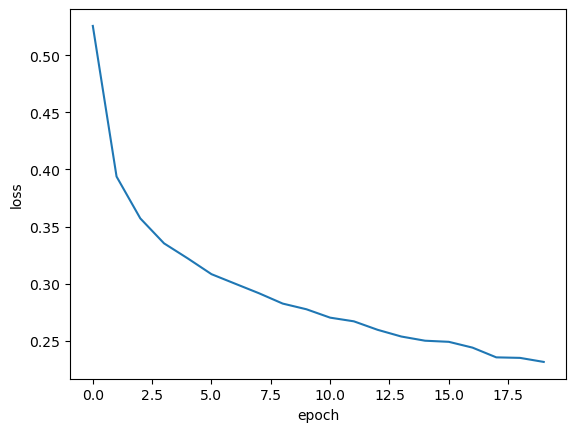

In [45]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')

history = model.fit(train_scaled, train_target, epochs=20, verbose=0)

plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

다음과 같이 손실이 감소한다. 이것이 더 나은 모델을 학습한 것일까? 반복 수를 늘리면 과대/과소적합의 가능성이 상당히 올라간다. 

### 검증 손실

In [46]:
model = model_fn()
model.compile(loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

In [47]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


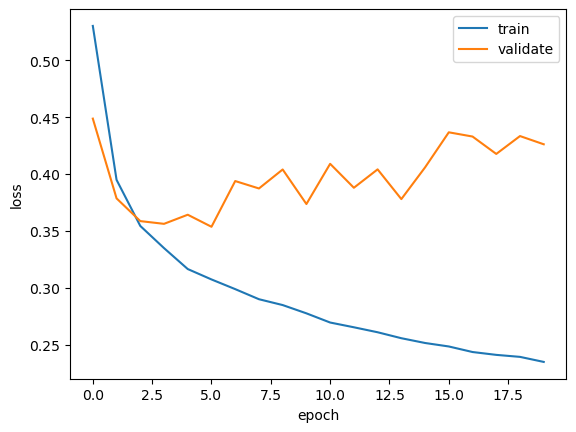

In [48]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validate'])

plt.show()

다섯 번째 epoch를 보면 train의 loss는 감소하지만 검증 셋의 val의 losss는 증가하는 경향을 보인다. 이것이 전형적인 과대적합 모델이다.

과대적합을 막기 위해 릿지, 라쏘 규제오 같은 것을 적용할 수 있다. 하지만 그 전에는 옵티마이저 하이어파라미터를 조정한다.

Adam 옵티마이저는 적응적 학습률을 사용하기 때문에 epoch가 진행되면서 학습률의 크기를 조정할 수 있다. Adam 옵티마이저를 적용 후, 다시 시각적 표현을 하자.

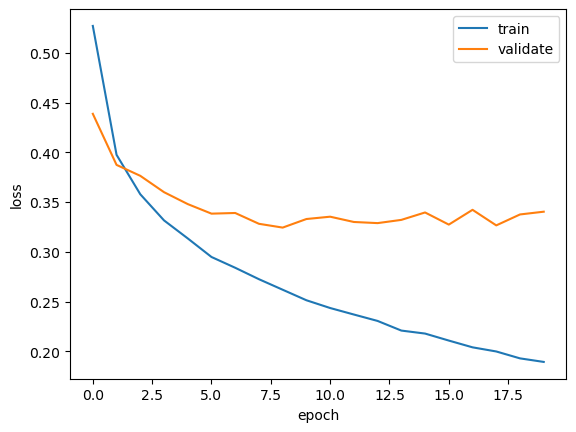

In [49]:
model = model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validate'])

plt.show()

위의 그래프와 달리 과대적합이 감소한 모습을 보인다. 

### 인공 신경망에서 사용하는 대표적인 규제 방법

##### 드롭아웃

드롭아웃은 다음 그림처럼 훈련 과정에서 층에 있는 뉴런을 랜덤하게 꺼서(뉴런의 츌력을 0으로 만듬) 과대적합을 막는다.

어떤 샘플을 처리할 때는 은닉층의 두 번째 뉴런이 드롭아웃이 되어 h2의 출력이 없다. 다른 샘플을 처리할 때에는 은닉층의 첫 번째 뉴런이 드롭아웃이 되어 h1의 출력이 없다. 

뉴런은 랜덤하게 드롭아웃 되고 얼마나 많은 뉴런을 드롭할 지는 우리가 정해야 할 또다른 하이퍼파라미터이다.

어떻게 드롭아웃이 과대적합을 막을까? 이전 층의 일부 뉴런이 랜덤하게 꺼지면 특정 뉴런에 과대하게 의존하는 것을 줄일 수 있다. 

In [50]:
#30%정도를 드롭아웃 한다.
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_16 (Flatten)        (None, 784)               0         
                                                                 
 dense_32 (Dense)            (None, 100)               78500     
                                                                 
 dropout_7 (Dropout)         (None, 100)               0         
                                                                 
 dense_33 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


드롭아웃은 학습을 할 때에 드롭아웃이 되어야 한다. 학습이 끝난 뒤에 평가 또는 예측을 수행할 때에는 드롭아웃이 적용되면 안된다. 그래야 학습된 모든 뉴런을 사용해야 올바른 예측을 수행할 수 있다.

텐서플로와 케라스에서는 위처럼 모델에 Dropout 층을 추가해도, 자동으로 평가와 예측을 할 때에는 드롭아웃을 적용하지 않는다.

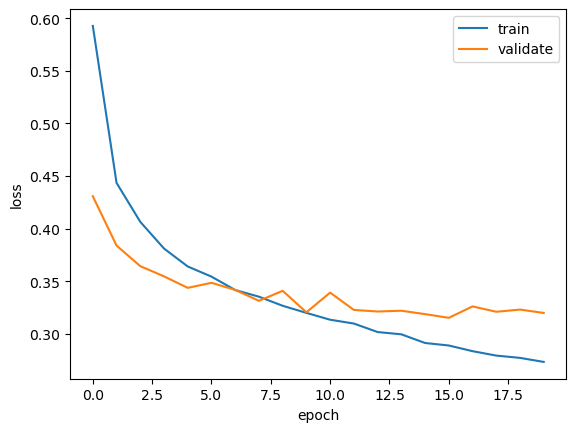

In [51]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validate'])

plt.show()

과대적합이 감소된 것을 볼 수 있다. 최적의 epoch는 10으로 보인다. 다시 epoch를 10으로 설정 후 학습시키자.

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_17 (Flatten)        (None, 784)               0         
                                                                 
 dense_34 (Dense)            (None, 100)               78500     
                                                                 
 dropout_8 (Dropout)         (None, 100)               0         
                                                                 
 dense_35 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


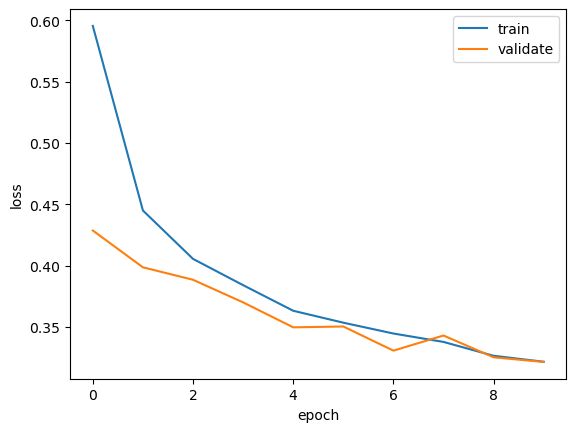

In [52]:
#30%정도를 드롭아웃 한다.
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
history = model.fit(train_scaled, train_target, epochs=10, verbose=0, validation_data=(val_scaled, val_target))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validate'])

plt.show()

Keras 모델은 학습된 모델의 파라미터를 저장하는 **save_weights()** 메서드를 제공한다.

In [53]:
model.save_weights('model-weights.h5')

또한 모델의 구조와 모델 파라미터를 함께 저장하는 save() 메서드도 제공한다.

In [54]:
model.save('model-whole.h5')

1. 학습하지 않는 새로운 모델을 생성 후, 모델의 파라미터만 저장된 model-weights.h5 파일에서 학습된 모델 파라미터만 읽어서 사용해보자.

In [55]:
model = model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.h5')

save_weights <-> load_weights

2. 이번에는 모델 전체를 파일에서 불어온다.

In [56]:
model = keras.models.load_model('model-whole.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 0s 558us/step - loss: 0.3214 - accuracy: 0.8833


[0.3213886618614197, 0.8833333253860474]

### Callback

콜백은 학습 과정 중간에 어떤 작업을 수행할 수 있게 하는 객체이다. 여기에서 사용할 ModelCheckPoint 콜백은 기본적으로 에포크마다 모델을 저장한다. 

save_best_only=True 매개변수를 지정하여 가장 낮은 검증 점수를 만드는 모델을 저장할 수 있다.

In [57]:
#30%정도를 드롭아웃 한다.
model = model_fn(keras.layers.Dropout(0.3))
model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)

model.fit(train_scaled, train_target, epochs=20, verbose=0, validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb])

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_19 (Flatten)        (None, 784)               0         
                                                                 
 dense_38 (Dense)            (None, 100)               78500     
                                                                 
 dropout_10 (Dropout)        (None, 100)               0         
                                                                 
 dense_39 (Dense)            (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [58]:
model = keras.models.load_model('best-model.h5')
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 0s 560us/step - loss: 0.3189 - accuracy: 0.8829


[0.31891658902168274, 0.8829166889190674]

여전히 20번의 에포크 동안 학습을 진행한다. 사실 검증 점수가 상승하기 시작하면, 그 이후는 과대적합이 더 커지기 때문에 훈련을 계속할 필요가 없다. 과대적합이 시작되기 전에 훈련을 미리 중지하는 것을 **조기종료**라 한다.

**조기종료**는 훈련 에포크 횟수를 제한하는 역할이지만, 모델이 과대적합되는 것을 막아 주기 때문에 규제 방법 중 하나라고 생각할 수 있다.

파라미터 중 patience는 연속 검증 점수가 향상되지 않으면 훈련을 종료시키는 파라미터이다. 즉 patience=2로 지정하면 2번 연속 검증 점수가 향상되지 않으면 학습을 중지한다.

또한 restore_best_weights 파라미터를 True로 설정하면 가장 낮은 검증 손실을 낸 모델 파라미터로 되돌린다.

**EarlyStopping 콜백을 ModelCheckpoint 콜백과 함께 사용하면 가장 낮은 검증 손싱릐 모델을 파일에 저장 후, 검증 손실이 다시 상승할 때 훈련을 중지할 수 있다. 또한 훈련을 중지한 다음 현재 모델의 파라미터를 최상의 파라미터로 되돌린다.**

In [59]:
model = model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)
early_stoppin_cb = keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(train_scaled, train_target, epochs=20, verbose=0, 
validation_data=(val_scaled, val_target), callbacks=[checkpoint_cb, early_stoppin_cb])

In [60]:
#12번째 epoch에서 학습이 종료되었다.
print(early_stoppin_cb.stopped_epoch)

9


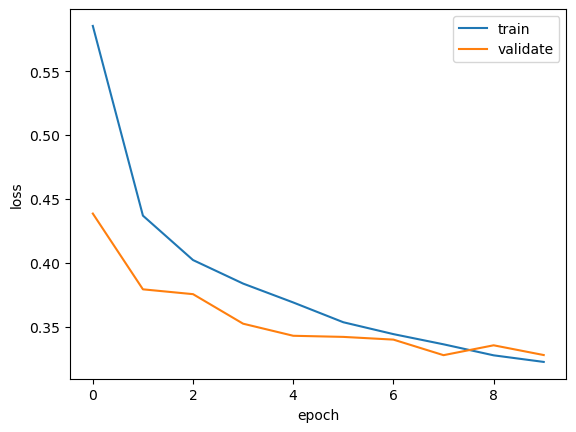

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validate'])

plt.show()

In [62]:
model.evaluate(val_scaled, val_target)

375/375 [==============================] - 0s 578us/step - loss: 0.3276 - accuracy: 0.8825


[0.32764002680778503, 0.8824999928474426]